# ML Experiments with Model Percentages

In [11]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import warnings

warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

directory = 'C:/Users/99451/Desktop/MODEL/2025/dixon_coles_model_predictions/_predictions.xlsx'
predictions = pd.read_excel(directory)
predictions['League'] = predictions['League'].str.capitalize()

predictions.tail()

,League,Home,Away,FT1,FTX,FT2,FTR,DC1X,DC12,DCX2,1.5O,2.5O,3.5U,4.5U,BTTS,HT1,HTX,HT2,HTR,HTDC1X,HTDC12,HTDCX2,HT0.5O,HT1.5U,H0.5O,A0.5O,H1.5O,A1.5O,H2.5U,A2.5U
593,Spain,Villarreal,Las Palmas,80.75,10.23,4.05,4-1,90.98,84.80,14.28,95.05,89.40,13.97,26.76,73.47,48.24,27.65,17.67,1-1,75.89,65.91,45.32,86.38,13.33,94.11,72.60,89.80,40.22,15.33,78.19
594,Spain2,Racing,Cartagena,68.72,12.88,18.37,1-0,81.60,87.09,31.25,75.24,55.89,66.46,82.82,46.78,68.93,18.63,9.65,1-0,87.56,78.58,28.28,86.15,41.27,87.22,57.77,60.97,21.37,66.05,94.29
595,Sweden,Brommapojkarna,Vasteras,59.54,19.90,20.55,1-0,79.44,80.09,40.45,74.64,51.94,70.21,85.48,49.47,60.22,28.16,10.65,1-0,88.38,70.87,38.81,79.77,52.92,83.75,60.78,54.23,24.08,72.59,93.09
596,Sweden,IFK Goteborg,GAIS,29.57,26.13,44.31,0-1,55.70,73.88,70.44,59.91,34.65,84.13,93.93,39.44,14.95,47.57,37.44,0-0,62.52,52.39,85.01,59.02,78.61,59.31,69.48,22.72,33.25,93.73,88.24
597,Turkey,Kayserispor,Besiktas,2.36,8.19,86.32,0-4,10.55,88.68,94.51,94.56,86.12,23.59,40.33,58.83,-0.18,0.85,17.28,0-4,0.67,17.10,18.13,17.62,0.33,58.60,95.50,23.06,89.62,90.32,19.88


# Finding Game Results

In [12]:
final =  pd.DataFrame()
liqa = ''
unique_leagues = predictions['League'].unique().tolist()

for i in unique_leagues:
    URL = "https://www.soccerstats.com/results.asp?league=" + i + "&pmtype=bydate"
    page = requests.get(URL)
    liqa = i
    soup = BeautifulSoup(page.content, "html.parser")
    results = soup.find(id="btable")
    sth = results.find_all("tr", class_="odd")
    sth


    date, league, home, away, ft, ht = [], [], [], [], [],[]
    for i in sth:
        date.append(i.find_all("td", align = 'right')[0].get_text(strip=True))
        league.append(liqa.capitalize())
        home.append(i.find_all("td", align = 'right')[1].get_text(strip=True))
        away.append(i.find("td", align = "left").get_text(strip = True))
        ft.append(i.find_all("td", align = 'center')[0].get_text(strip = True))
        try:
            ht.append(i.find_all("td", align = 'center')[2].get_text(strip = True))
        except IndexError as e:
            ht.append('NA')#print("Last output before error occurred:", i.find_all("td", align = 'center'))

    data = {'Date': date, 'League': league,'Home': home, 'Away': away, 'FT': ft, 'HT': ht}

# Create a DataFrame from the dictionary
    df = pd.DataFrame(data)

# Replace empty strings with NaN
    #next_df = df[(df['Date'] == formatted_date) & (df['HT'] == '')]
    df.replace('', pd.NA, inplace=True)

# Drop rows with NaN values
    df_cleaned = df.dropna()

#For Half-Time Results
    hthg, htag = [], []
    for i in df_cleaned['HT']:
        if i == 'NA':
            hthg.append('NA')
            htag.append('NA')
        elif i == '+' or i == '-':
            hthg.append('NA')
            htag.append('NA')
        else:
            try:
                hthg.append(int(i[1]))
                htag.append(int(i[3]))
            except IndexError as e:
                print("Last output before error occurred:", i)



#For Full-Time Results
    hg, ag, tg = [], [], []
    for i in df_cleaned['FT']:
        if len(i) < 5 or ':' in i:
            hg.append('NA')
            ag.append('NA')
            tg.append('NA')
        else:
            try:
                hghg = int(i.split(' - ')[0])
                hg.append(hghg)
                agag = int(i.split(' - ')[1])
                ag.append(agag)
                tg.append(hghg + agag)
            except:
                print(hghg + agag)

    
    df_cleaned['FTHG'], df_cleaned['FTAG'], df_cleaned['FTTG'] = hg, ag, tg
    df_cleaned['HTHG'], df_cleaned['HTAG'] = hthg, htag
    df_cleaned['HTTG'] = df_cleaned['HTHG'] + df_cleaned['HTAG']
    
    final = pd.concat([final, df_cleaned], ignore_index=True)
    
final = final[final['HT'] != 'NA']

# Example: Fix the 'date' column by removing the weekday and extra punctuation
final['Date'] = final['Date'].str.extract(r'(\d{1,2} \w{3})')  # Extract day and month part
final['Date'] = final['Date'] + ' 2024'  # Append the year

# Convert to datetime format
final['Date'] = pd.to_datetime(final['Date'], format='%d %b %Y', errors='coerce')

# Filter rows before September 6th, 2024
final_filtered = final[final['Date'] >= pd.Timestamp('2024-09-06')]
combined = pd.concat([final_filtered.head(), final_filtered.tail()])

combined

,Date,League,Home,Away,FT,HT,FTHG,FTAG,FTTG,HTHG,HTAG,HTTG
39,2024-09-13,Spain,Real Betis,Leganes,2 - 0,(0-0),2,0,2,0,0,0
40,2024-09-14,Spain,Mallorca,Villarreal,1 - 2,(0-1),1,2,3,0,1,1
41,2024-09-14,Spain,Espanyol,Alaves,3 - 2,(1-1),3,2,5,1,1,2
42,2024-09-14,Spain,Sevilla FC,Getafe,1 - 0,(1-0),1,0,1,1,0,1
43,2024-09-14,Spain,Real Sociedad,Real Madrid,0 - 2,(0-0),0,2,2,0,0,0
4227,2024-09-28,England,Nottm Forest,Fulham,0 - 1,(0-0),0,1,1,0,0,0
4228,2024-09-28,England,Wolverhampton,Liverpool,1 - 2,(0-1),1,2,3,0,1,1
4229,2024-09-29,England,Ipswich Town,Aston Villa,2 - 2,(1-2),2,2,4,1,2,3
4230,2024-09-29,England,Manchester Utd,Tottenham,0 - 3,(0-1),0,3,3,0,1,1
4231,2024-09-30,England,Bournemouth,Southampton,3 - 1,(3-0),3,1,4,3,0,3


# Choosing the Matches on XLSX File

In [13]:
# Combine df and final based on 'League', 'Home', and 'Away'
combined_df = pd.merge(predictions, final_filtered, on=['League', 'Home', 'Away'], how='left')
combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]
combined_df = combined_df.dropna(subset=['Date'])
combined_df = combined_df.drop_duplicates(subset=['Home', 'Away'])
combined_df = combined_df.reset_index(drop=True) #Regularize index of combined_df
combined_df.head()

,League,Home,Away,FT1,FTX,FT2,FTR,DC1X,DC12,DCX2,1.5O,2.5O,3.5U,4.5U,BTTS,HT1,HTX,HT2,HTR,HTDC1X,HTDC12,HTDCX2,HT0.5O,HT1.5U,H0.5O,A0.5O,H1.5O,A1.5O,H2.5U,A2.5U,Date,FT,HT,FTHG,FTAG,FTTG,HTHG,HTAG,HTTG
0,Spain,Mallorca,Real Sociedad,32.39,55.18,12.43,0-0,87.57,44.82,67.61,30.21,7.67,98.22,99.66,18.17,6.82,78.45,14.73,0-0,85.27,21.55,93.18,23.24,96.50,47.18,28.97,13.46,4.67,97.29,99.48,2024-09-17,1 - 0,(1-0),1.0,0.0,1.0,1.0,0.0,1.0
1,Netherlands,FC Twente,Heerenveen,80.07,10.05,4.41,4-1,90.12,84.48,14.46,94.66,89.56,12.60,24.63,74.77,73.65,16.27,6.92,1-0,89.92,80.57,23.19,85.15,43.20,93.69,73.96,89.68,42.59,14.44,75.86,2024-09-17,2 - 0,(2-0),2.0,0.0,2.0,2.0,0.0,2.0
2,England5,AFC Fylde,Southend Utd,22.77,25.42,51.80,1-1,48.19,74.57,77.22,80.76,56.89,65.50,82.10,58.39,36.56,26.84,36.41,1-0,63.40,72.97,63.25,82.07,61.75,68.28,83.74,31.86,54.21,89.04,72.61,2024-09-17,2 - 1,(1-0),2.0,1.0,3.0,1.0,0.0,1.0
3,Netherlands2,FC Volendam,FC Dordrecht,22.83,30.24,46.90,1-1,53.07,69.73,77.14,90.49,67.39,54.24,73.05,70.69,8.57,15.84,65.37,0-2,24.41,73.94,81.21,85.35,17.64,76.29,86.87,42.19,60.25,82.35,66.78,2024-09-17,2 - 0,(2-0),2.0,0.0,2.0,2.0,0.0,2.0
4,Netherlands2,Jong Ajax,Jong AZ,57.98,28.28,13.68,1-1,86.26,71.66,41.96,88.53,64.22,57.80,76.06,63.78,41.11,52.09,6.77,0-0,93.20,47.88,58.86,51.74,83.27,88.94,66.83,64.64,30.25,62.11,89.90,2024-09-17,1 - 2,(1-0),1.0,2.0,3.0,1.0,0.0,1.0


# Checking the Predictions for BTTS

In [15]:
bttsr = []

for i in range(len(combined_df)):
    if combined_df['FTHG'].iloc[i] != 0 and combined_df['FTAG'].iloc[i] != 0:
        bttsr.append(1)
    else:
        bttsr.append(0)

combined_df['BTTSR'] = bttsr
combined_df['3.5O'] = 100 - combined_df['3.5U']
combined_df.tail()

,League,Home,Away,FT1,FTX,FT2,FTR,DC1X,DC12,DCX2,1.5O,2.5O,3.5U,4.5U,BTTS,HT1,HTX,HT2,HTR,HTDC1X,HTDC12,HTDCX2,HT0.5O,HT1.5U,H0.5O,A0.5O,H1.5O,A1.5O,H2.5U,A2.5U,Date,FT,HT,FTHG,FTAG,FTTG,HTHG,HTAG,HTTG,BTTSR,3.5O
578,Spain,Villarreal,Las Palmas,80.75,10.23,4.05,4-1,90.98,84.80,14.28,95.05,89.40,13.97,26.76,73.47,48.24,27.65,17.67,1-1,75.89,65.91,45.32,86.38,13.33,94.11,72.60,89.80,40.22,15.33,78.19,2024-09-30,3 - 1,(1-0),3.0,1.0,4.0,1.0,0.0,1.0,1,86.03
579,Spain2,Racing,Cartagena,68.72,12.88,18.37,1-0,81.60,87.09,31.25,75.24,55.89,66.46,82.82,46.78,68.93,18.63,9.65,1-0,87.56,78.58,28.28,86.15,41.27,87.22,57.77,60.97,21.37,66.05,94.29,2024-09-30,1 - 2,(0-1),1.0,2.0,3.0,0.0,1.0,1.0,1,33.54
580,Sweden,Brommapojkarna,Vasteras,59.54,19.90,20.55,1-0,79.44,80.09,40.45,74.64,51.94,70.21,85.48,49.47,60.22,28.16,10.65,1-0,88.38,70.87,38.81,79.77,52.92,83.75,60.78,54.23,24.08,72.59,93.09,2024-09-30,2 - 1,(0-0),2.0,1.0,3.0,0.0,0.0,0.0,1,29.79
581,Sweden,IFK Goteborg,GAIS,29.57,26.13,44.31,0-1,55.70,73.88,70.44,59.91,34.65,84.13,93.93,39.44,14.95,47.57,37.44,0-0,62.52,52.39,85.01,59.02,78.61,59.31,69.48,22.72,33.25,93.73,88.24,2024-09-30,2 - 0,(1-0),2.0,0.0,2.0,1.0,0.0,1.0,0,15.87
582,Turkey,Kayserispor,Besiktas,2.36,8.19,86.32,0-4,10.55,88.68,94.51,94.56,86.12,23.59,40.33,58.83,-0.18,0.85,17.28,0-4,0.67,17.10,18.13,17.62,0.33,58.60,95.50,23.06,89.62,90.32,19.88,2024-09-30,0 - 3,(0-0),0.0,3.0,3.0,0.0,0.0,0.0,0,76.41


# Preparing Data for the Model

In [18]:
X = combined_df[['1.5O', '2.5O', '3.5O', 'BTTS', 'H0.5O', 'A0.5O', 'H1.5O', 'A1.5O']]
y = combined_df['BTTSR']
X.tail()

,1.5O,2.5O,3.5O,BTTS,H0.5O,A0.5O,H1.5O,A1.5O
578,95.05,89.40,86.03,73.47,94.11,72.60,89.80,40.22
579,75.24,55.89,33.54,46.78,87.22,57.77,60.97,21.37
580,74.64,51.94,29.79,49.47,83.75,60.78,54.23,24.08
581,59.91,34.65,15.87,39.44,59.31,69.48,22.72,33.25
582,94.56,86.12,76.41,58.83,58.60,95.50,23.06,89.62


# Checking Different Models!

SVM: Average ROC AUC Score = 0.4987
Naive Bayes: Average ROC AUC Score = 0.5081
Logistic Regression: Average ROC AUC Score = 0.5113
Gradient Boosting: Average ROC AUC Score = 0.4864
Random Forest: Average ROC AUC Score = 0.4799


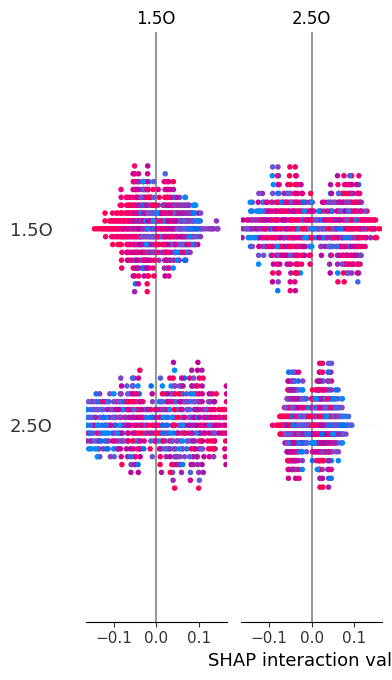

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import make_scorer, roc_auc_score
import shap
from sklearn.ensemble import RandomForestClassifier

# Models
models = {
    "SVM": SVC(probability=True),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Random Forest": RandomForestClassifier()
}

# Dictionary to store average ROC AUC scores
roc_auc_scores = {}

# 5-fold cross-validation for each model
for model_name, model in models.items():
    # roc_auc_score expects probability estimates, hence we need `probability=True` in SVM
    scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    roc_auc_scores[model_name] = scores.mean()

# Print the average ROC AUC scores
for model_name, score in roc_auc_scores.items():
    print(f"{model_name}: Average ROC AUC Score = {score:.4f}")

# Fit the Random Forest model to check SHAP values
rf_model = RandomForestClassifier()
rf_model.fit(X, y)

# Initialize SHAP explainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X)

# Plot SHAP summary for feature importance
# If so, remove the last column
if len(shap_values) == 2:
    shap_values = shap_values[1] 

shap.summary_plot(shap_values, X, feature_names=X.columns)